<a href="https://colab.research.google.com/github/SAPNILPATEL/Image_Captioning_Using_Attention/blob/main/Image_captioning_using_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install keras==2.13.1

In [2]:
# !pip install tensorflow==2.13.0

In [3]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle
import gdown
import zipfile

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import add
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2024-11-30 14:11:19.116474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 14:11:19.156504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
image_path = "Flickr8k_Dataset"
dir_Flickr_text = "Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


In [5]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)
data.head(20)

index                   filename  \
0      0  1000268201_693b08cb0e.jpg   
1      1  1000268201_693b08cb0e.jpg   
2      2  1000268201_693b08cb0e.jpg   
3      3  1000268201_693b08cb0e.jpg   
4      4  1000268201_693b08cb0e.jpg   
5      0  1001773457_577c3a7d70.jpg   
6      1  1001773457_577c3a7d70.jpg   
7      2  1001773457_577c3a7d70.jpg   
8      3  1001773457_577c3a7d70.jpg   
9      4  1001773457_577c3a7d70.jpg   
10     0  1002674143_1b742ab4b8.jpg   
11     1  1002674143_1b742ab4b8.jpg   
12     2  1002674143_1b742ab4b8.jpg   
13     3  1002674143_1b742ab4b8.jpg   
14     4  1002674143_1b742ab4b8.jpg   
15     0  1003163366_44323f5815.jpg   
16     1  1003163366_44323f5815.jpg   
17     2  1003163366_44323f5815.jpg   
18     3  1003163366_44323f5815.jpg   
19     4  1003163366_44323f5815.jpg   

                                              caption  
0   a child in a pink dress is climbing up a set o...  
1               a girl going into a wooden building .  
2    a little girl climbing into a wooden playhouse .  
3   a little girl climbing the stairs to her playh...  
4   a little girl in a pink dress going into a woo...  
5          a black dog and a spotted dog are fighting  
6   a black dog and a tri-colored dog playing with...  
7   a black dog and a white dog with brown spots a...  
8   two dogs of different breeds looking at each o...  
9     two dogs on pavement moving toward each other .  
10  a little girl covered in paint sits in front o...  
11  a little girl is sitting in front of a large p...  
12  a small girl in the grass plays with fingerpai...  
13  there is a girl with pigtails sitting in front...  
14  young girl with pigtails painting outside in t...  
15  a man lays on a bench while his dog sits by him .  
16  a man lays on the bench to which a white dog i...  
17  a man sleeping on a bench outside with a white...  
18  a shirtless man lies on a park bench with his ...  
19  man laying on bench holding leash of dog sitti...

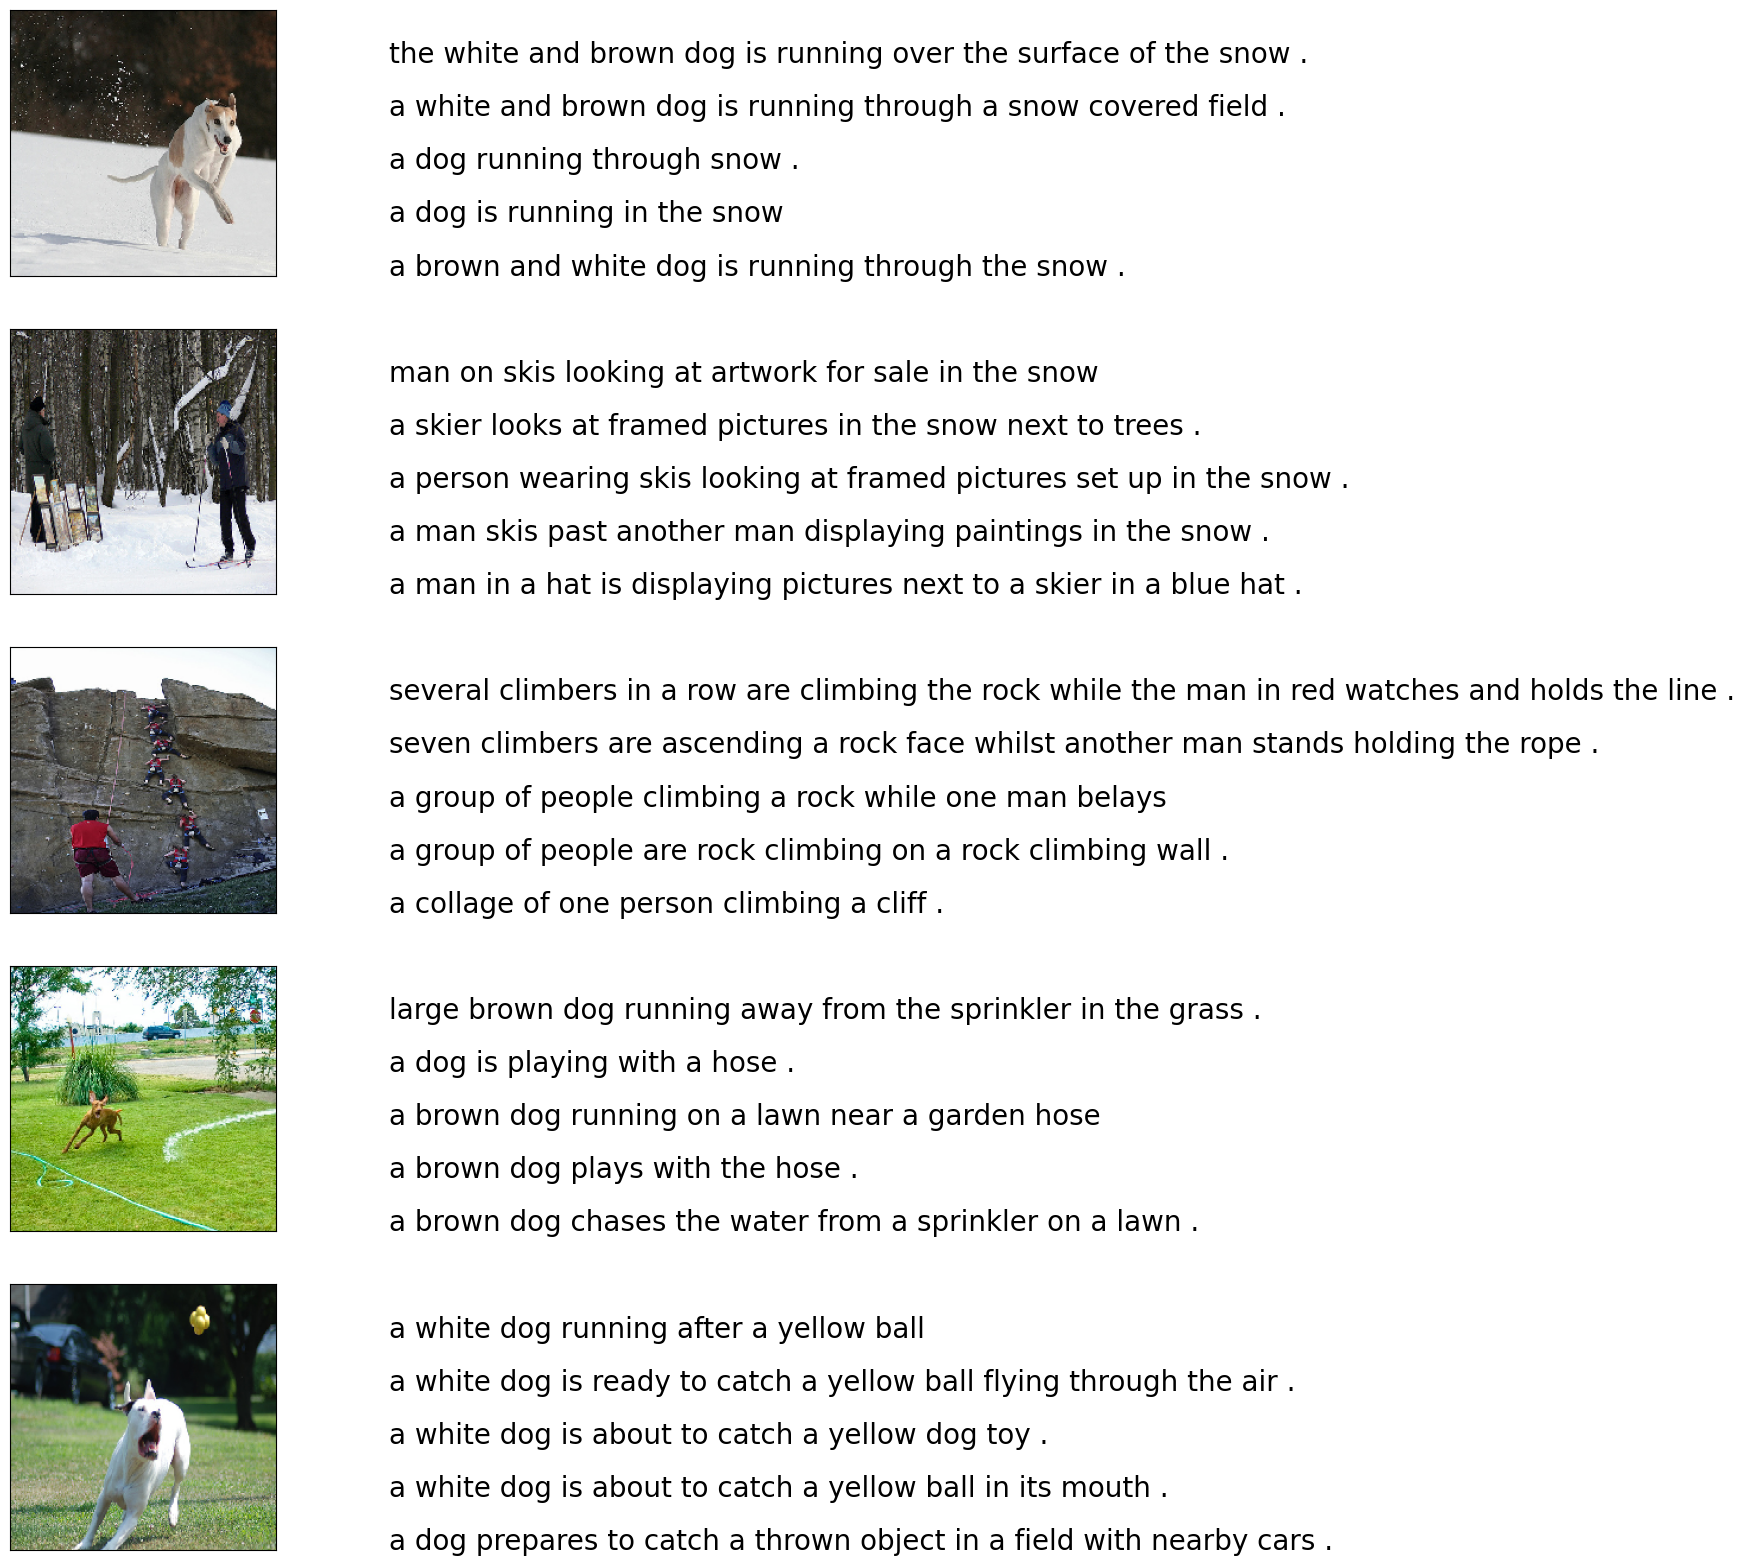

In [6]:
from tensorflow.keras.utils import load_img,img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [7]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [8]:
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [9]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40455
len(caption) : 40455


In [10]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [11]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [12]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [13]:
PATH = "Flickr8k_Dataset/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [14]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/1001773457_577c3a7d70.jpg']

In [15]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [16]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [17]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [18]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 40000
len(all_captions) : 40000


In [19]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2024-11-30 14:11:33.959906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46521 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:51:00.0, compute capability: 8.6


In [21]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [22]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [23]:
%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

  0%|          | 0/127 [00:00<?, ?it/s]2024-11-30 14:11:37.632774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-11-30 14:11:39.712301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 127/127 [00:38<00:00,  3.27it/s]

CPU times: user 2min 2s, sys: 7.62 s, total: 2min 10s
Wall time: 38.8 s


In [24]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [25]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [26]:
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [27]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
    return min(len(t) for t in tensor)

min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [28]:

# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

In [30]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 64

In [31]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [32]:
class InceptionV3_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(InceptionV3_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [33]:
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_activation='sigmoid',
                                   recurrent_initializer='glorot_uniform')

In [34]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)



  def call(self, x, features, hidden):

    # features shape ==> (64,49,256) ==> Output from ENCODER

    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
    # you get 1 at the last axis because you are applying score to self.Vattn


    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''
    attention_weights = tf.nn.softmax(score, axis=1)
    # attention_weights shape == (64, 49, 1)


    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)


    # x shape after passing through embedding == (64, 1, 256)
    x = self.embedding(x)

    # x shape after concatenation == (64, 1,  512)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)
    # output shape == (64 * 512)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [35]:
encoder = InceptionV3_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [37]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [38]:
EPOCHS = 50
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2024-11-30 14:12:47.155968: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x73ba982b78e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 14:12:47.156004: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-11-30 14:12:47.162463: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 14:12:47.351236: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 Batch 0 Loss 2.5741
Epoch 1 Batch 100 Loss 1.4402
Epoch 1 Batch 200 Loss 1.4487
Epoch 1 Batch 300 Loss 1.2644
Epoch 1 Batch 400 Loss 1.2079
Epoch 1 Loss 1.444602
Time taken for 1 epoch 103.21495842933655 sec

Epoch 2 Batch 0 Loss 1.2055
Epoch 2 Batch 100 Loss 1.1664
Epoch 2 Batch 200 Loss 1.1369
Epoch 2 Batch 300 Loss 1.2187
Epoch 2 Batch 400 Loss 1.0601
Epoch 2 Loss 1.126094
Time taken for 1 epoch 58.435884952545166 sec

Epoch 3 Batch 0 Loss 1.1417
Epoch 3 Batch 100 Loss 0.9646
Epoch 3 Batch 200 Loss 0.9662
Epoch 3 Batch 300 Loss 0.9832
Epoch 3 Batch 400 Loss 0.9166
Epoch 3 Loss 1.020203
Time taken for 1 epoch 58.12174201011658 sec

Epoch 4 Batch 0 Loss 0.8841
Epoch 4 Batch 100 Loss 0.8756
Epoch 4 Batch 200 Loss 0.9259
Epoch 4 Batch 300 Loss 0.9127
Epoch 4 Batch 400 Loss 0.8139
Epoch 4 Loss 0.949560
Time taken for 1 epoch 56.706538438797 sec

Epoch 5 Batch 0 Loss 0.9837
Epoch 5 Batch 100 Loss 0.9243
Epoch 5 Batch 200 Loss 0.8206
Epoch 5 Batch 300 Loss 0.8973
Epoch 5 Batch 400 

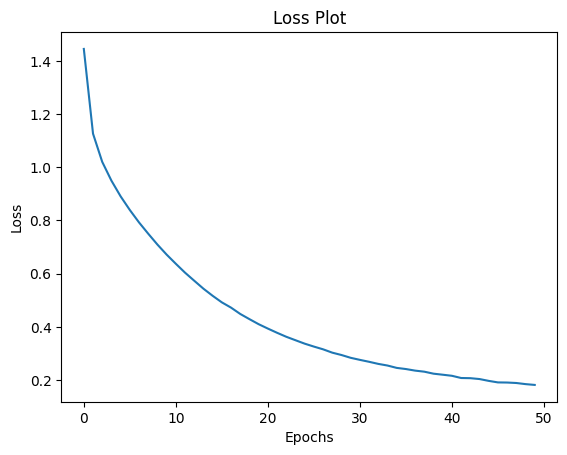

In [39]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [40]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [41]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## captions on the validation set

BLEU-1 score: 44.44444444444444
BLEU-2 score: 23.570226039551585
BLEU-3 score: 2.1262855015914923e-91
BLEU-4 score: 7.241926111174567e-153
Real Caption: dog leaps to catch ball
Predicted Caption: the brown dog jumping to catch the ball <end>


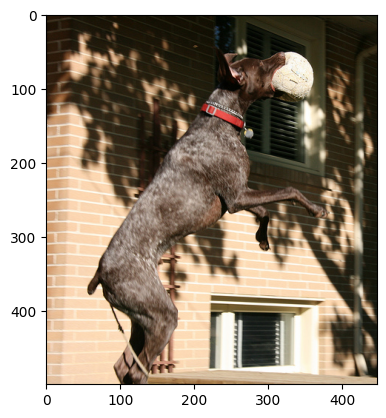

In [42]:

from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'Flickr8k_Dataset/3544673666_ffc7483c96.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "dog leaps to catch ball"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


# # opening the image
# Image.open('/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1969573381_5ecfae4c80.jpg')

BLEU-1 score: 61.91984998215584
BLEU-2 score: 42.29931028018367
BLEU-3 score: 2.8522426749429815e-91
BLEU-4 score: 9.032704947274395e-153
Real Caption: young girl is playing in fountain of water
Predicted Caption: young girl plays in fountain water <end>


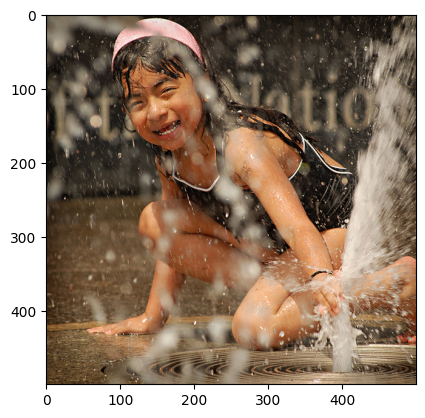

In [43]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
# image = '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1969573381_5ecfae4c80.jpg'
image = 'Flickr8k_Dataset/3484649669_7bfe62080b.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "young girl is playing in fountain of water"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


# # opening the image
# Image.open('/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1969573381_5ecfae4c80.jpg')

[['group', 'of', 'men', 'stand', 'outside', 'glass', 'and', 'steel', 'building']]
['two', 'grocery', 'store', '<end>']
BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: group of men stand outside glass and steel building
Predicted Caption: two grocery store <end>


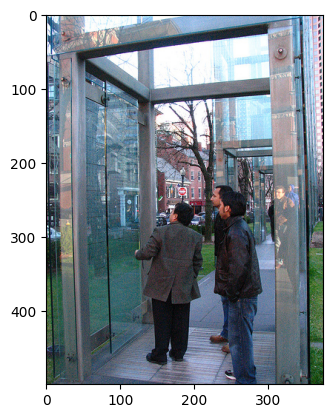

In [44]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'Flickr8k_Dataset/347543966_b2053ae78c.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "group of men stand outside glass and steel building"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
print(reference)
candidate = caption
print(candidate)
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


# # opening the image
# Image.open('/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1969573381_5ecfae4c80.jpg')

[['a', 'man', 'lays', 'on', 'a', 'bench', 'while', 'his', 'dog', 'sits', 'by', 'him', '.']]
['shirtless', 'man', 'lies', 'on', 'bench', 'with', 'dog', '<end>']
BLEU-1 score: 26.763071425949512
BLEU-2 score: 5.645769805042435e-153
BLEU-3 score: 1.1134317697687857e-183
BLEU-4 score: 8.200055153470431e-230
Real Caption: a man lays on a bench while his dog sits by him .
Predicted Caption: shirtless man lies on bench with dog <end>


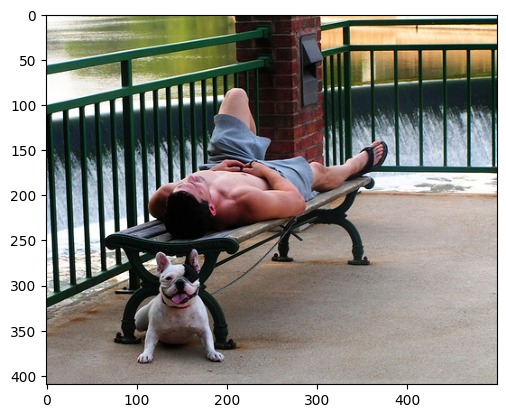

In [45]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'Flickr8k_Dataset/1003163366_44323f5815.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "a man lays on a bench while his dog sits by him ."
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
print(reference)
candidate = caption
print(candidate)
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [46]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
import matplotlib.pyplot as plt
 
def clean_caption(caption, tokenizer):
    # Remove unwanted tokens (e.g., <start>, <end>, <unk>) and join to form a clean caption
    cleaned_caption = [tokenizer.index_word[i] for i in caption if i not in [0, tokenizer.word_index['<start>'], tokenizer.word_index['<end>'], tokenizer.word_index['<unk>']]]
    return cleaned_caption
 
# def calculate_bleu_score(caption, real_caption):
#     # BLEU Score calculations
#     reference = [real_caption]  # Real caption is a list of words
#     print(f"The reference is {reference}")
#     candidate = caption
#     print(f"The candidate is {candidate}")
#     bleu_1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0))
#     print(bleu_1)
#     bleu_2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#     print(bleu_2)
#     bleu_3 = sentence_bleu(reference, candidate, weights=(0.3, 0.3, 0.3, 0))
#     print(bleu_3)
#     bleu_4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
#     print(bleu_4)
#     return bleu_1, bleu_2, bleu_3, bleu_4
 
# Assuming `evaluate` is the function that generates the predicted caption
def calculate_average_bleu_score(img_name_val, cap_val, tokenizer, evaluate):
    total_bleu_1, total_bleu_2, total_bleu_3, total_bleu_4 = 0, 0, 0, 0
    num_images = len(img_name_val)
    print(num_images)
    for rid in range(num_images):
        # print(rid)
        image = img_name_val[rid]
        # Get the real caption by decoding the tokenized captions from cap_val
        # real_caption = clean_caption(cap_val[rid], tokenizer)
        real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
 
        # Get the predicted caption from the model
        caption, attention_plot = evaluate(image)
        # cleaned_caption = [word for word in caption if word !=  '<end>']
        # Calculate BLEU scores for this image
        #remove "<unk>" in result
        for i in caption:
            if i=="<unk>":
                caption.remove(i)

        for i in real_caption:
            if i=="<unk>":
                real_caption.remove(i)

        #remove <end> from result
        result_join = ' '.join(caption)
        result_final = result_join.rsplit(' ', 1)[0]

        real_appn = []
        real_appn.append(real_caption.split())
        reference = real_appn
        # print(reference)
        candidate = caption
        # print(candidate)

        bleu_1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
        # print(f"BLEU-1 score: {bleu_1}")
        bleu_2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
        # print(f"BLEU-2 score: {bleu_2}")
        bleu_3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
        # print(f"BLEU-3 score: {bleu_3}")
        bleu_4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
        # print(f"BLEU-4 score: {bleu_4}")
        
        # bleu_1, bleu_2, bleu_3, bleu_4 = calculate_bleu_score(caption, real_caption)
        # Add the scores to the total sum
        total_bleu_1 += bleu_1
        total_bleu_2 += bleu_2
        total_bleu_3 += bleu_3
        total_bleu_4 += bleu_4
    # Calculate average BLEU scores
    avg_bleu_1 = total_bleu_1 / num_images
    avg_bleu_2 = total_bleu_2 / num_images
    avg_bleu_3 = total_bleu_3 / num_images
    avg_bleu_4 = total_bleu_4 / num_images
    print(f"Average BLEU-1 score: {avg_bleu_1 * 100:.2f}")
    print(f"Average BLEU-2 score: {avg_bleu_2 * 100:.2f}")
    print(f"Average BLEU-3 score: {avg_bleu_3 * 100:.2f}")
    print(f"Average BLEU-4 score: {avg_bleu_4 * 100:.2f}")
 
# Assuming `img_name_val` is the list of image file paths in the validation set
# and `cap_val` is the list of corresponding captions encoded as sequences of word indices
# Assuming `tokenizer` is the tokenizer used for encoding/decoding captions
 
# Call the function to calculate average BLEU score on the validation set
calculate_average_bleu_score(img_name_val, cap_val, tokenizer, evaluate)

8000


Average BLEU-1 score: 25.00
Average BLEU-2 score: 9.72
Average BLEU-3 score: 4.17
Average BLEU-4 score: 1.47


In [47]:
print(img_name_val)

['Flickr8k_Dataset/2352414953_10f3cd0f1f.jpg', 'Flickr8k_Dataset/3081182021_22cfa18dd4.jpg', 'Flickr8k_Dataset/3104909823_0f41dd8be6.jpg', 'Flickr8k_Dataset/2956413620_d59de03a06.jpg', 'Flickr8k_Dataset/1501297480_8db52c15b0.jpg', 'Flickr8k_Dataset/2285741931_07159a21f2.jpg', 'Flickr8k_Dataset/2258951972_92763fddab.jpg', 'Flickr8k_Dataset/3537520829_aab733e16c.jpg', 'Flickr8k_Dataset/3404552106_f516df0f5b.jpg', 'Flickr8k_Dataset/2463067409_78188c584c.jpg', 'Flickr8k_Dataset/2053777548_108e54c826.jpg', 'Flickr8k_Dataset/3324375078_9441f72898.jpg', 'Flickr8k_Dataset/3182558164_488b819f14.jpg', 'Flickr8k_Dataset/3477681171_b1bb8b211d.jpg', 'Flickr8k_Dataset/2554570943_122da6438f.jpg', 'Flickr8k_Dataset/2949497756_be8e58e6bd.jpg', 'Flickr8k_Dataset/3603064161_a8f3b6455d.jpg', 'Flickr8k_Dataset/2874728371_ccd6db87f3.jpg', 'Flickr8k_Dataset/1806580620_a8fe0fb9f8.jpg', 'Flickr8k_Dataset/3506560025_8d0f4f9ac4.jpg', 'Flickr8k_Dataset/349889354_4b2889a9bd.jpg', 'Flickr8k_Dataset/3348385580_10b53

BLEU-1 score: 35.588329018524796
BLEU-2 score: 32.689967585126034
BLEU-3 score: 32.12360867175481
BLEU-4 score: 23.899976771375066
Real Caption: child in blue shirt smiles about what is in his hand
Predicted Caption: child in blue shirt looks like the camera <end>


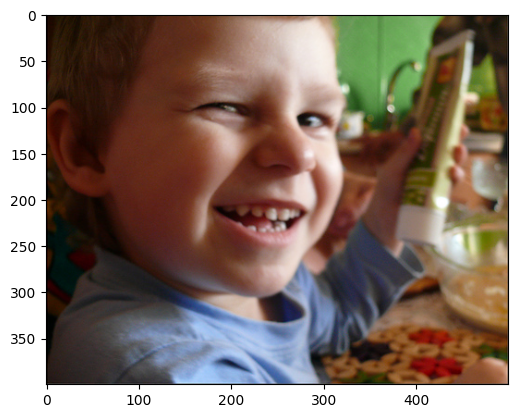

In [53]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'Flickr8k_Dataset/2352414953_10f3cd0f1f.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "child in blue shirt smiles about what is in his hand"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
# print(reference)
candidate = caption
# print(candidate)
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 57.14285714285714
BLEU-2 score: 43.643578047198474
BLEU-3 score: 37.519859868268625
BLEU-4 score: 5.395774370246973e-76
Real Caption: biker does trick on ramp
Predicted Caption: boy does trick on wooden ramp <end>


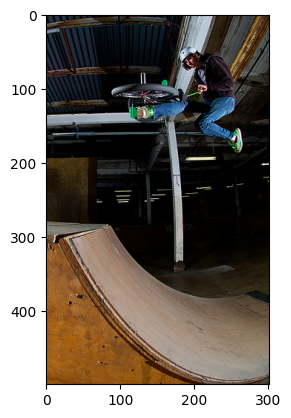

In [54]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'Flickr8k_Dataset/3081182021_22cfa18dd4.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "biker does trick on ramp"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
# print(reference)
candidate = caption
# print(candidate)
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 14.285714285714285
BLEU-2 score: 5.637975647982814e-153
BLEU-3 score: 1.4284901392909564e-183
BLEU-4 score: 1.1200407237786664e-229
Real Caption: boy tries to put screen on window
Predicted Caption: shirtless child in red shorts holding up window screen that has fallen out <end>


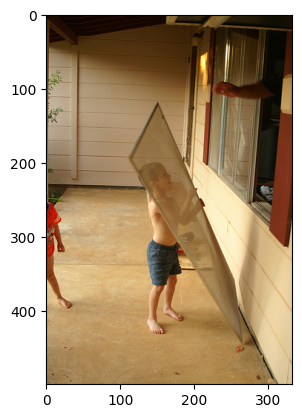

In [55]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'Flickr8k_Dataset/1501297480_8db52c15b0.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "boy tries to put screen on window"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
# print(reference)
candidate = caption
# print(candidate)
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 10.000000000000002
BLEU-2 score: 4.717068855239749e-153
BLEU-3 score: 1.2835318765197404e-183
BLEU-4 score: 1.0244914152188952e-229
Real Caption: A boy jumping in a field
Predicted Caption: young boy and young child runs down dirt road <end>


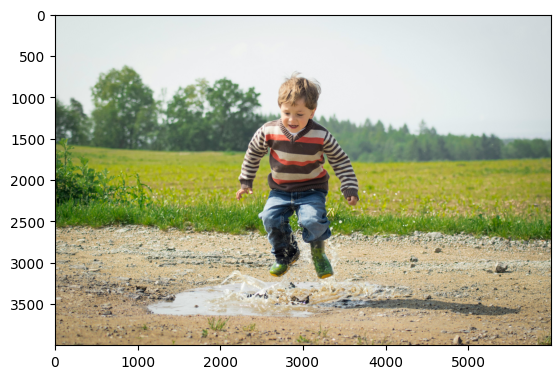

In [56]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'test1.jpg'


# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = "A boy jumping in a field"
caption, attention_plot = evaluate(image)

# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
# print(reference)
candidate = caption
# print(candidate)
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)